In [1]:
# These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../..")
# Importing GemPy
import gempy as gp
# Embedding matplotlib figures in the notebooks
%matplotlib inline
# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt


In [25]:
# set resolution, extent and input data
geo_data = gp.create_data([0,1000,0,1000,0,1000],resolution=[25,25,25], 
                        path_o = os.pardir+"/data/input_data/jan_models/model2_orientations.csv",
                        path_i = os.pardir+"/data/input_data/jan_models/model2_surface_points.csv") 

Active grids: ['regular']


In [86]:
# define series and assign surfaces
gp.map_series_to_surfaces(geo_data, {"Strat_Series": ('rock2','rock1'),"Basement_Series":('basement')})

,surface,series,order_surfaces,isBasement,color,id
1,rock2,Strat_Series,1,False,#9f0052,1
0,rock1,Strat_Series,2,False,#ff0080,2
2,basement,Basement_Series,1,True,#ff80ff,3


In [27]:
# define the interpolator
interp_data = gp.set_interpolation_data(geo_data, compile_theano=True,
                                        theano_optimizer='fast_compile')

Compiling theano function...
Compilation Done!


In [28]:
#calcualte the solution
sol = gp.compute_model(geo_data)

../..\gempy\core\solution.py:258: UserWarning: Surfaces not computed due to: marching_cubes_lewiner() got an unexpected keyword argument 'mask'
  warnings.warn('Surfaces not computed due to: ' + str(e))


In [90]:
geo_data.surfaces.colors.change_colors()

Click to select new colors.


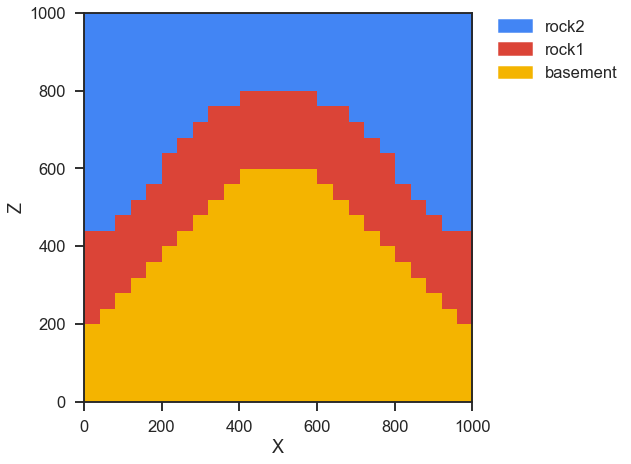

In [91]:
# Plot cross section, which is basically the whole model in this example
gp.plot.plot_section(geo_data, cell_number=0)

In [92]:
geo_data.surfaces

,surface,series,order_surfaces,isBasement,color,id
1,rock2,Strat_Series,1,False,#4285F4,1
0,rock1,Strat_Series,2,False,#DB4437,2
2,basement,Basement_Series,1,True,#F4B400,3


In [93]:
import gempy as gp
#importlib.reload(kriging)
from gempy.assets import kriging

In [32]:
test_data = np.array([[110,0,510,2],[910,0,510,1],[510,0,530,1],[310,0,410,5],
                     [110,500,510,2],[910,500,510,1],[510,500,530,1],[310,500,410,5]])

In [41]:
# Creating a kriging object with model solution and input domain (by id) and conditioning data
kriging_model = kriging.kriging_model(model=sol, domain=[2],data=test_data)

#kriging_model.krig_grid = np.round(kriging_model.krig_grid,0)

# set some parameters, not final yet
kriging_model.range_ = 150
kriging_model.moving_neighbourhood  = 'all'
kriging_model.set_kriging_type('OK')
kriging_model.nugget = 0.5
kriging_model.sill = np.var(test_data[:,3])

kriging_model.create_kriged_field()

kriging_model.results_df.head()

,X,Y,Z,est_value,est_variance
0,20.0,20.0,260.0,2.319185,2.888915
1,20.0,20.0,300.0,2.325383,2.826717
2,20.0,20.0,340.0,2.318082,2.745554
3,20.0,20.0,380.0,2.293718,2.639707
4,20.0,60.0,260.0,2.321757,2.891730


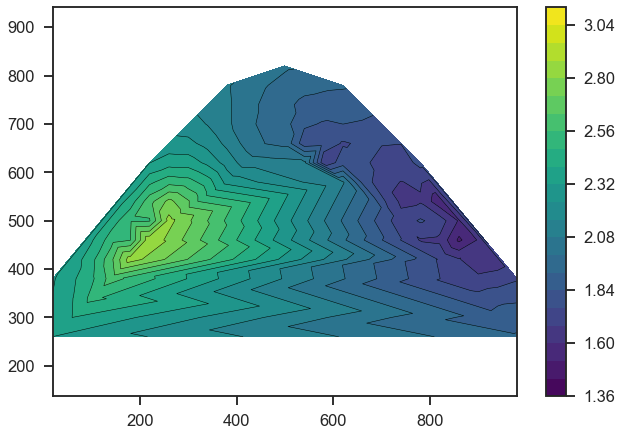

In [42]:
x = kriging_model.results_df['X'].values
y = kriging_model.results_df['Z'].values
prop = kriging_model.results_df['est_value'].values
var = kriging_model.results_df['est_variance'].values


fig1, ax1 = plt.subplots()
ax1.axis('equal')


tcf = ax1.tricontourf(x, y, prop, 20, cmap='viridis')
tcf_lines = ax1.tricontour(x, y, prop, 20, linewidths=0.5, colors='k')
fig1.colorbar(tcf)

plt.show()

In [43]:
# Creating a kriging object with model solution and input domain (by id) and conditioning data
#kriging_model = kriging.kriging_model(model=sol, domain=[2],data=test_data)

#kriging_model.krig_grid = np.round(kriging_model.krig_grid,0)

# change moving neighbourhood for simulation
kriging_model.moving_neighbourhood  = 'n_closest'


kriging_model.create_gaussian_field()

kriging_model.results_sim_df.head()

,X,Y,Z,sim_value,est_variance
0,60.0,500.0,420.0,3.395752,2.329164
1,500.0,300.0,780.0,0.138206,2.894108
2,820.0,140.0,460.0,3.097794,2.613191
3,820.0,580.0,420.0,3.174516,2.564142
4,60.0,60.0,300.0,2.712215,2.731562


In [44]:
# results_df and results_sim_df are basically all you need for plotting I guess (hope)
# (plus maybe the solution (sol) that I pass to the object)

# 2D section plotting:
# - as for gempy section
# - either value or variance
# - either results or simulation results (if calculated)
# - either contourf or block
# - plot on section of model (maybe change colors of background model)
# - allow to plot on subplot if thats not automatically possible
# - plot data true/false

# 3D Plotting (blocks)
# - Miguel suggests Pyvista for this 
#    (Testing in Ipyvolume worked but has limits)
# - Most useful and cool for first run would be block model
# - allow threshhold to show only certain blocks

# variogram/covariance function plotting (Jan)
# - easily plot used function 
# - show nugget range and sill 
# - allow to plot on subplot if thats not automatically possible


In [45]:
import ipyvolume as ipv
import numpy as np

from matplotlib.cm import ScalarMappable as SM

In [46]:
def plot_3D_blocks(model, threshold):
    
    x = kriging_model.results_df['X'].values
    y = kriging_model.results_df['Y'].values
    z = kriging_model.results_df['Z'].values
    
    vals = kriging_model.results_df['est_value'].values
    vals_color = SM(cmap='viridis').to_rgba(vals)
    
    mask = vals > threshold
    
    x = x[mask]
    y = y[mask]
    z = z[mask]
    vals = vals[mask]
    
    block_size = (kriging_model.sol.grid.regular_grid.extent[1]
                  -kriging_model.sol.grid.regular_grid.extent[0])/(kriging_model.sol.grid.regular_grid.resolution[0])/10
    
    ipv.figure()
    ipv.pylab.scatter(x, y, z, color=vals_color[mask], size=block_size, marker="box")

    ipv.xlim(kriging_model.sol.grid.regular_grid.extent[0], kriging_model.sol.grid.regular_grid.extent[1])
    ipv.ylim(kriging_model.sol.grid.regular_grid.extent[2], kriging_model.sol.grid.regular_grid.extent[3])
    ipv.zlim(kriging_model.sol.grid.regular_grid.extent[4], kriging_model.sol.grid.regular_grid.extent[3])
    ipv.show()

In [47]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

In [48]:
interact(plot_3D_blocks, model=fixed(kriging_model), threshold=(1,2.8,0.1));

interactive(children=(FloatSlider(value=1.8, description='threshold', max=2.8, min=1.0), Output()), _dom_class…

In [94]:
from gempy.plot import visualization_2d

In [95]:
plot = visualization_2d.PlotData2D(geo_data)

In [96]:
plot._cmap

In [99]:

x = sol.grid.regular_grid.values[:,0]
y = sol.grid.regular_grid.values[:,1]
z = sol.grid.regular_grid.values[:,2]
    
vals = np.round(sol.lith_block, 0)
#vals_color = SM(cmap='viridis').to_rgba(vals)

vals_color = SM(cmap=plot._cmap).to_rgba(vals)
    
mask = vals > 0
x = x[mask]
y = y[mask]
z = z[mask]
vals = vals[mask]
    
block_size = (kriging_model.sol.grid.regular_grid.extent[1]
                  -kriging_model.sol.grid.regular_grid.extent[0])/(kriging_model.sol.grid.regular_grid.resolution[0])/10
    
ipv.figure()
ipv.pylab.scatter(x, y, z, color=vals_color[mask], size=block_size, marker="box")

ipv.xlim(kriging_model.sol.grid.regular_grid.extent[0], kriging_model.sol.grid.regular_grid.extent[1])
ipv.ylim(kriging_model.sol.grid.regular_grid.extent[2], kriging_model.sol.grid.regular_grid.extent[3])
ipv.zlim(kriging_model.sol.grid.regular_grid.extent[4], kriging_model.sol.grid.regular_grid.extent[3])
ipv.show()

In [18]:
#Pyvista testrun

In [19]:
# sphinx_gallery_thumbnail_number = 4
import numpy as np
import pyvista as pv
from pyvista import examples

In [20]:
# Load a simple example mesh
dataset = examples.load_uniform()
dataset.set_active_scalar("Spatial Cell Data")

In [21]:
dataset

UniformGrid (0x1a901bb4228)
  N Cells:	729
  N Points:	1000
  X Bounds:	0.000e+00, 9.000e+00
  Y Bounds:	0.000e+00, 9.000e+00
  Z Bounds:	0.000e+00, 9.000e+00
  Dimensions:	10, 10, 10
  Spacing:	1.000e+00, 1.000e+00, 1.000e+00
  N Arrays:	2

In [22]:
# Compute volumes and areas
sized = dataset.compute_cell_sizes()

# Grab volumes for all cells in the mesh
cell_volumes = sized.cell_arrays["Volume"]

In [23]:
# Compute the total volume of the mesh
volume = dataset.volume

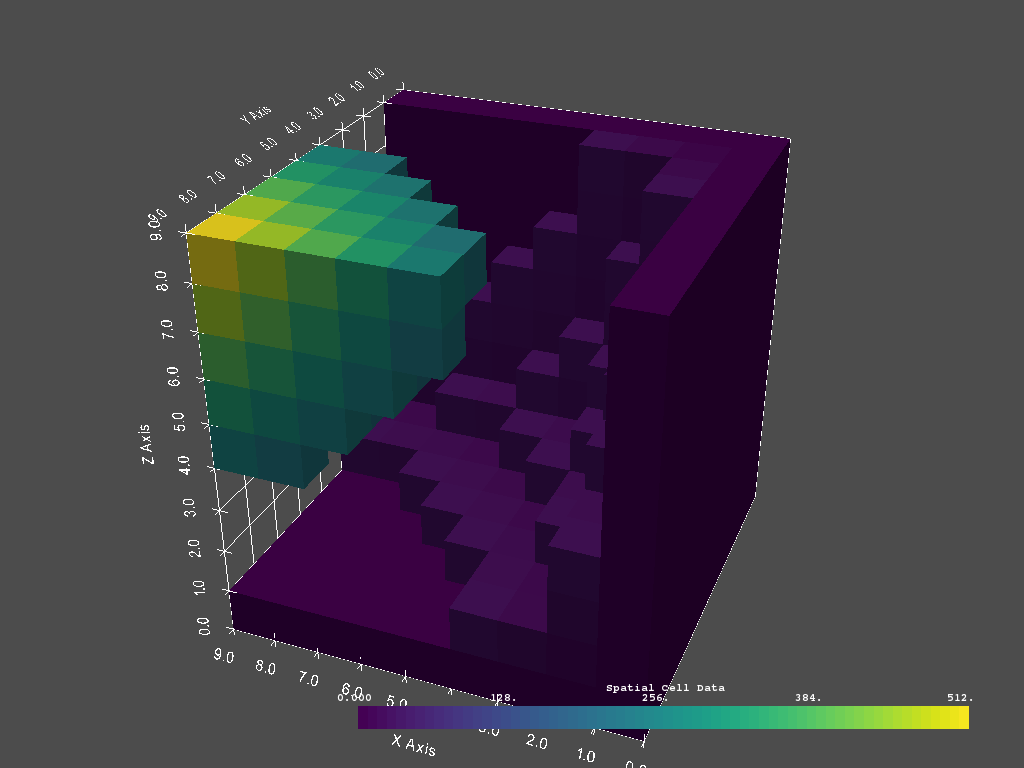

In [24]:
threshed = dataset.threshold_percent([0.05, 0.40], invert=True)
threshed.plot(show_grid=True, cpos=[-2, 5, 3])